<img src="https://10botics.com/logo_jnb.png" width="300"/>

# Using pose estimation model

<img src="./resource/estimation_on_image_sample.png" width=300 />

In this lesson, you will learn:

1. Import the tensorflow libraries
2. Download a pose detection model - movenet
3. Load a sample image
4. Resize the sample image
5. Run the model
6. Draw detected keypoints on the image

## Preparation

Refer to install_tf.sh if you have not installed the tensorflow required libraries. 

## Import the libraries

In [51]:
import tensorflow as tf
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

print("TF version:", tf.__version__)

TF version: 2.10.0


## Download the model

We are going to use movenet as the sample. It is an ultra fast and accurate pose detection model. For more information about movenet, check below:

- https://www.tensorflow.org/hub/tutorials/movenet
- https://blog.tensorflow.org/2021/05/next-generation-pose-detection-with-movenet-and-tensorflowjs.html
- https://storage.googleapis.com/movenet/MoveNet.SinglePose%20Model%20Card.pdf

In [52]:
# Download the model 
!wget -nc -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite

# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

## Define a function to use the model

In [53]:
def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()    
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

### Model Input

`interpreter.get_input_details()` returns the specification of the input the model requires

In [54]:
interpreter.get_input_details()

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 192, 192,   3], dtype=int32),
  'shape_signature': array([  1, 192, 192,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [55]:
# Define model input size
model_input_size = 192

### Model Output

`interpreter.get_output_details()` returns the specification of the output the model generates.

In [56]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 332,
  'shape': array([ 1,  1, 17,  3], dtype=int32),
  'shape_signature': array([ 1,  1, 17,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

## 1st Attempt: Feed the image to the model

### Load a sample image

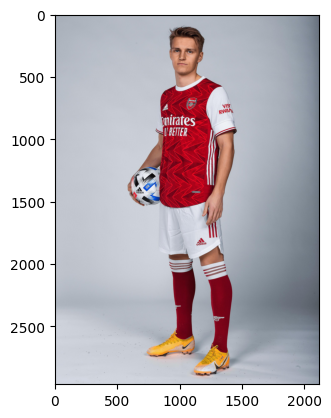

In [57]:
# Show the image
image_path = './resource/input_image4.jpeg'
import matplotlib.image as mpimg
image = mpimg.imread(image_path)
imgplot = plt.imshow(image)
plt.show()

In [58]:
# The following line will generate an error! What's the problem?
keypoints_with_scores = movenet(image)

ValueError: Cannot set tensor: Dimension mismatch. Got 3 but expected 4 for input 0.

### Error

- What is the meaning of this error message?
- What is our image shape?

In [59]:
image.shape

(2965, 2118, 3)

## 2nd Attempt: Adding dimension

In [60]:
expanded_image = tf.expand_dims(image, axis=0)

In [61]:
expanded_image.shape

TensorShape([1, 2965, 2118, 3])

In [62]:
# The following line will generate an error! What's the problem?

keypoints_with_scores = movenet(expanded_image)

ValueError: Cannot set tensor: Dimension mismatch. Got 2965 but expected 192 for dimension 1 of input 0.

## 3rd Attempt: Resize the image

- Our model only accept a 192x192 image.
- What is the size of our image?
- How do we reduce it into 192x192?

In [63]:
resized_image = tf.image.resize_with_pad(expanded_image, model_input_size, model_input_size)

In [64]:
print(resized_image.shape)

(1, 192, 192, 3)


TypeError: Invalid shape (1, 192, 192, 3) for image data

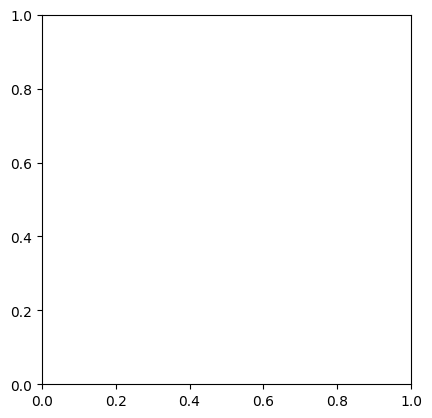

In [65]:
# The following lines will generate an error! What's the problem?

imgplot = plt.imshow(resized_image)
plt.show()

### Exercise #1 - Fix the error

In [ ]:
imgplot = plt.imshow(resized_image)
plt.show()

#### Answer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


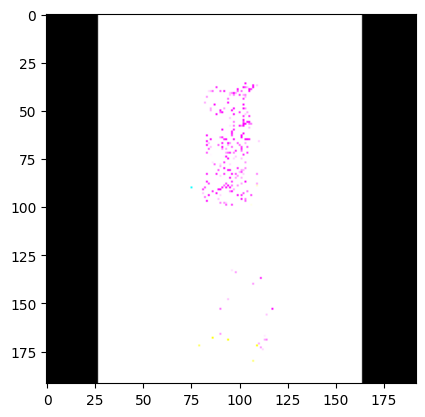

In [66]:
imgplot = plt.imshow(resized_image[0])
plt.show()

### Conform to imshow standard

According to imshow documentation, the image data supported array shapes are:

- (M, N, 3): an image with RGB values (0-1 float or 0-255 int).

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

In [67]:
# Check the left uppermost pixel
resized_image[0][0][0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [68]:
# Check a pixel somewhere in the centre
resized_image[0][100][100]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([226.31027, 229.31027, 238.31027], dtype=float32)>

In [69]:
type(resized_image[0][100][100].numpy()[0])

numpy.float32

#### The solution

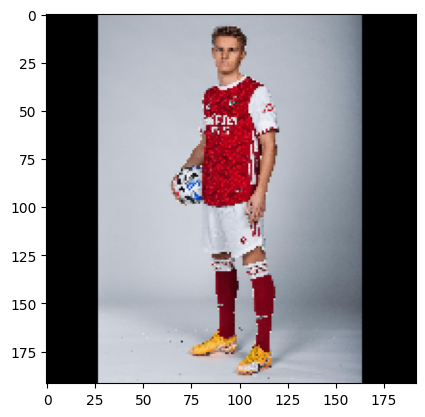

In [70]:
imgplot = plt.imshow(resized_image[0].numpy() / 255.0)
plt.show()

### Run the model again

In [71]:
# Run model inference.
keypoints_with_scores = movenet(resized_image)
print(keypoints_with_scores)
keypoints_with_scores.shape

[[[[0.11880878 0.47523507 0.43016967]
   [0.10242134 0.49981618 0.36462   ]
   [0.09832451 0.4629445  0.75382113]
   [0.11061504 0.5243973  0.75382113]
   [0.10651821 0.4547508  0.49981618]
   [0.22123012 0.56536585 0.6350124 ]
   [0.22532699 0.4342665  0.8029834 ]
   [0.35232943 0.6063344  0.6350124 ]
   [0.34413573 0.43016967 0.75382113]
   [0.47523507 0.5694627  0.8808236 ]
   [0.4178791  0.3851043  0.5694627 ]
   [0.48752564 0.53668785 0.8029834 ]
   [0.4711382  0.45065394 0.700562  ]
   [0.6800778  0.5735596  0.6350124 ]
   [0.6759809  0.4711382  0.6350124 ]
   [0.9013079  0.5735596  0.75382113]
   [0.8726299  0.4793319  0.84395194]]]]


(1, 1, 17, 3)

## Interpret the model output

In [72]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}


### Reorganize the points into a more readable format

In [73]:
sides = ["left" , "right"]
body_parts = ["shoulder", "hip", "ankle", "knee"]

points = dict()

for side in sides:
    points[side] = dict()
    for body_part in body_parts:
        points[side][body_part] = keypoints_with_scores[0][0][KEYPOINT_DICT[f"{side}_{body_part}"]]


print(points)

{'left': {'shoulder': array([0.22123012, 0.56536585, 0.6350124 ], dtype=float32), 'hip': array([0.48752564, 0.53668785, 0.8029834 ], dtype=float32), 'ankle': array([0.9013079 , 0.5735596 , 0.75382113], dtype=float32), 'knee': array([0.6800778, 0.5735596, 0.6350124], dtype=float32)}, 'right': {'shoulder': array([0.22532699, 0.4342665 , 0.8029834 ], dtype=float32), 'hip': array([0.4711382 , 0.45065394, 0.700562  ], dtype=float32), 'ankle': array([0.8726299 , 0.4793319 , 0.84395194], dtype=float32), 'knee': array([0.6759809, 0.4711382, 0.6350124], dtype=float32)}}


In [74]:
points['left']['shoulder']

array([0.22123012, 0.56536585, 0.6350124 ], dtype=float32)

In [75]:
points['left']['knee']

array([0.6800778, 0.5735596, 0.6350124], dtype=float32)

## Annotate the points on the image

### Draw the annotation on the original image

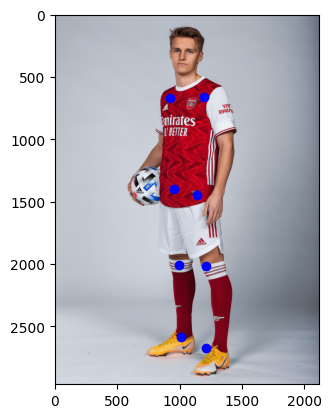

In [76]:
def annotate_and_show(image, points):

    height, width, _ = image.shape
    
    plt.imshow(image /255.0)
    
    for side in sides:
        for body_part in body_parts:            
            absolute_x = points[side][body_part][1] * width
            absolute_y = points[side][body_part][0] * height
            # print(f"{side}_{body_part}, x = {absolute_x} , y = {absolute_y}")
            plt.plot(absolute_x, absolute_y, 'bo')
    
    plt.show()

annotate_and_show(image, points)


### Draw the annotation on the resized and padded image

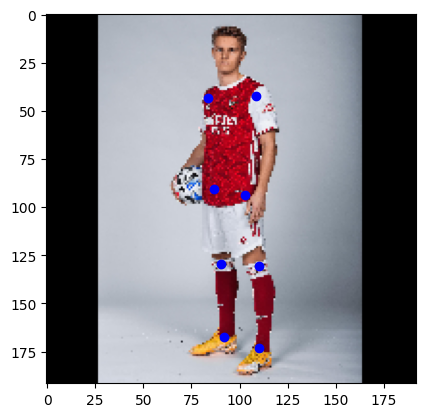

In [77]:
annotate_and_show(resized_image[0], points)

### Compare the two output

Which one is more accurate? Why?

<img src="../resource/model_image_compare.png" width=600/>

## Consolidate our work

In [78]:
def read_image(image_path):
    # Show the image

    import matplotlib.image as mpimg
    image = mpimg.imread(image_path)
    
    return image    

def convert_to_movenet_format(image):
    expanded_image = tf.expand_dims(image, axis=0)    
    resized_image = tf.image.resize_with_pad(expanded_image, model_input_size, model_input_size)
    return resized_image


def reoganize_output(movenet_output):
    sides = ["left" , "right"]
    body_parts = ["shoulder", "hip", "ankle", "knee"]
    
    points = dict()
    
    for side in sides:
        points[side] = dict()
        for body_part in body_parts:
            points[side][body_part] = movenet_output[0][0][KEYPOINT_DICT[f"{side}_{body_part}"]]

    return points

    

### Let's try different images

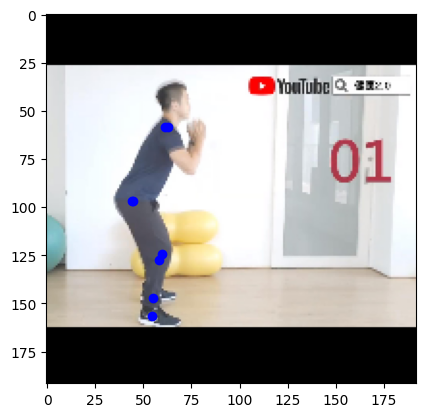

In [79]:
# image_path = './resource/input_image.jpeg'
image_path = './resource/input_image2.jpeg'
# image_path = './resource/input_image3.jpeg'
# image_path = './resource/input_image4.jpeg'

image = read_image(image_path)
movenet_image = convert_to_movenet_format(image)
movenet_output = movenet(movenet_image)
points = reoganize_output(movenet_output)
annotate_and_show(movenet_image[0], points)


### Exercse 1: Left blue and right red

Annotate the left hand side body part using blue dot and right hand side using red

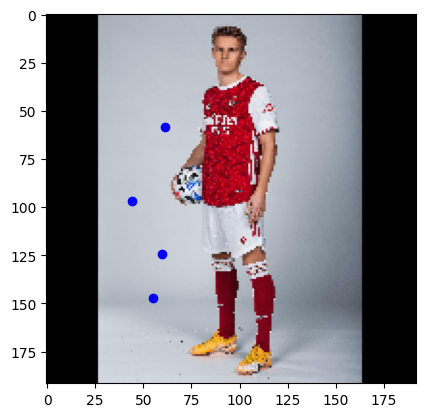

In [80]:
def annotate_and_show(image, points):

    height, width, _ = image.shape
    
    plt.imshow(image /255.0)
    
    for side in sides:
        for body_part in body_parts:            
            absolute_x = points[side][body_part][1] * width
            absolute_y = points[side][body_part][0] * height            
            
            if side == "left":
                plt.plot(absolute_x, absolute_y, 'bo')

    plt.show()

annotate_and_show(resized_image[0], points)


#### Answer

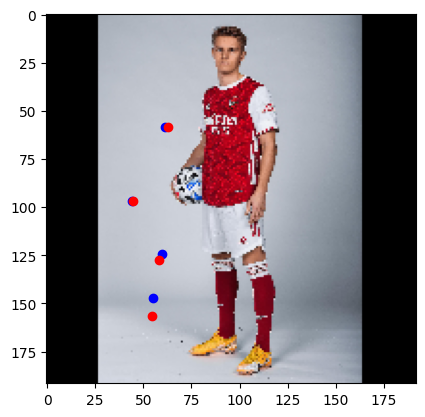

In [81]:
def annotate_and_show(image, points):

    height, width, _ = image.shape
    
    plt.imshow(image /255.0)
    
    for side in sides:
        for body_part in body_parts:            
            absolute_x = points[side][body_part][1] * width
            absolute_y = points[side][body_part][0] * height            
            
            if side == "left":
                plt.plot(absolute_x, absolute_y, 'bo')
            else:
                plt.plot(absolute_x, absolute_y, 'ro')
    
    plt.show()

annotate_and_show(resized_image[0], points)


<hr/>

## Congratulation! You have finished this chapter.

This jupyter notebook is created by 10Botics. <br>
For permission to use in school, please contact info@10botics.com <br>
All rights reserved. 2024.